In [2]:
import pymongo, re
import nltk
from collections import OrderedDict, namedtuple

stop_words = nltk.corpus.stopwords.words('english')

client = pymongo.MongoClient (host="da1.eecs.utk.edu")
db = client ['fdac16']
issues = db ['A1_issues']
descr = {}
for iss in issues.find():
    who = iss['reporter']['display_name']
    text = iss ['content']['raw']
    if who in descr: 
        text = descr[who] + ' ' + text
    descr[who] = text
    
def clean (t):
    t = t.lower()
    t = re.sub('[^A-Za-z0-9]+', ' ', t)
    return (t)
  
tgs=list()
ms=list()
for who in descr:
    m = clean(descr[who])
    tag = who
    if m is not None:
      tgs.append(tag)
      ms.append(m)
    else:
      print(who)

print(len(tgs))
    
ldoc = namedtuple('ldoc', 'words tags')
docs = []
for l in enumerate([ (w,t) for w,t in zip(ms, tgs) ]):
  words=l[1][0].split()
  tg=l[1][1]
  docs.append(ldoc(words, [ tg ]))

47


In [3]:
import numpy as np
import gzip,collections,gensim.models.doc2vec
from gensim.models import Doc2Vec
from random import shuffle
import multiprocessing
cores = multiprocessing.cpu_count()


mod = Doc2Vec(dm=1, dm_mean=1, size=200, window=10, negative=20, hs=0, min_count=5, 
              workers=cores) 
mod.build_vocab(docs)

In [4]:
dl = docs[:]  # for reshuffling per pass
alpha, min_alpha, passes = (0.025, 0.001, 200)
alpha_delta = (alpha - min_alpha) / passes
for epoch in range(passes):
 shuffle(dl)
 mod.alpha, mod.min_alpha = alpha, alpha
 mod.train(dl)
 alpha -= alpha_delta

In [5]:
for t in  tgs:
    print (t)
    #res = similar (t,1)
    print (mod.docvecs.most_similar([ t ], topn=3))

Jonathan Yoder
[('Joshua Tolen', 0.526013970375061), ('Walton Macey', 0.5186365842819214), ('Tyler Stuessi', 0.4862537384033203)]
Alex Cauthen
[('Caleb Mennen', 0.6074556112289429), ('Joshua Tolen', 0.5745890140533447), ('Hans Kodi', 0.5409350395202637)]
Chris Craig
[('jmoscato', 0.5651696920394897), ('Sarah Schaffer', 0.5279206037521362), ('Preston Shires', 0.524784505367279)]
Gray Pickney
[('Preston Shires', 0.5324568152427673), ('Hans Kodi', 0.5157437324523926), ('Chris Craig', 0.5109119415283203)]
Xiao Zhou
[('Seth Rausch', 0.5565357804298401), ('Kelley Deuso', 0.4963275194168091), ('Alex Cauthen', 0.4741355776786804)]
John Qiu
[('Andrew Valesky', 0.4625672996044159), ('jdiamon3', 0.42729032039642334), ('Idan Kanter', 0.41661199927330017)]
Tyler Stuessi
[('Tianxiang Chen', 0.5579409599304199), ('Joshua Tolen', 0.5251314640045166), ('Hans Kodi', 0.517180860042572)]
Tyler Shields
[('Sarah Schaffer', 0.5546998977661133), ('Hans Kodi', 0.4780395030975342), ('Preston Shires', 0.47374975

In [6]:
#cosine similarity
def similar (a, b):
    a1 = mod.docvecs[a]
    b1 = mod.docvecs[b]
    a2 = np.sum(a1*a1)
    b2 = np.sum(b1*b1)
    return (np.dot(a1, b1)/np.sqrt(a2)/np.sqrt(b2))

#do we reproduce internal function most_similar?
print (similar('Justin Nguyen', 'Stephen McNally'))

#Now create the matrix representing each document
m = len(tgs)
X = np.array([]).reshape(0,len(mod.docvecs[0]))
for t in tgs:
    #print (mod.docvecs[t])
    X = np.vstack([X, mod.docvecs[t] ])

0.584348


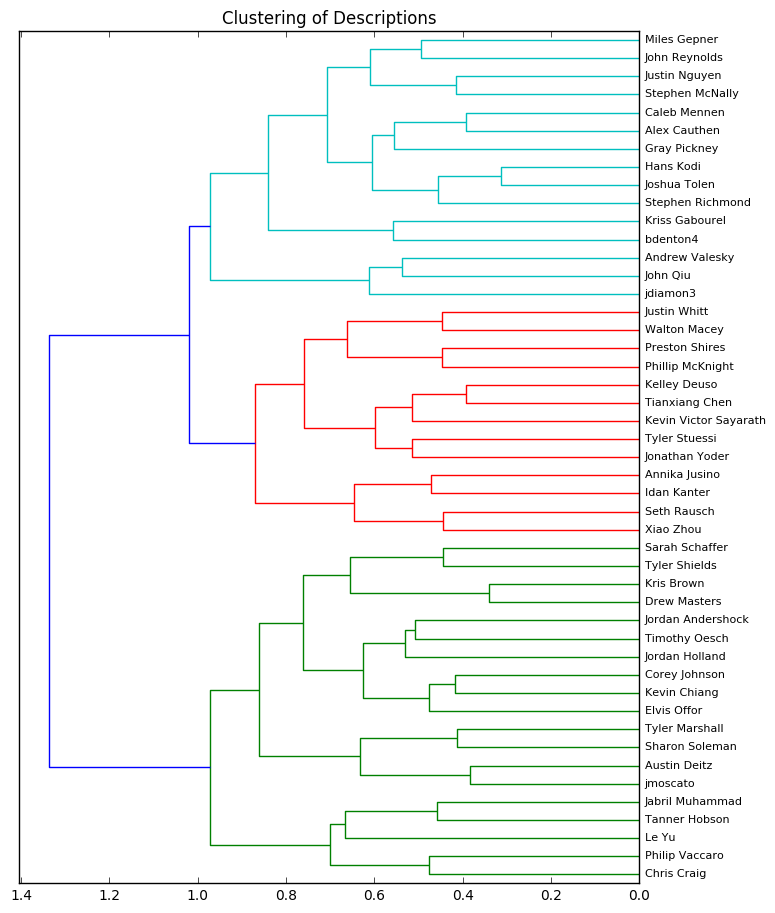

In [28]:
from scipy.cluster.hierarchy import linkage, ward, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

dist1 = pdist(X, 'cosine')
# Do clustering
linkage_matrix = linkage(dist1,method='complete')
#print(linkage_matrix)
# Plot results
fig = plt.figure(1, figsize=(8, 11))
plt.clf()
ddata = dendrogram(linkage_matrix,
               color_threshold=1,
               p=97,
               labels=tgs,
               truncate_mode='none',
               orientation='left',
                show_leaf_counts=True,
               )
plt.title("Clustering of Descriptions")
#fig.savefig("A1Groups.png")


In [30]:
print(len(tgs))

47


In [31]:
#save results for analysis using alternative packages
import sys
f=open("A1.docvec.matrix.csv","w")
for t in mod.docvecs.doctags.keys():
   f.write(t)
   for v in mod.docvecs[t]:  
     f.write(';'+"{:1.12e}".format(v))
   f.write('\n')